In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle

import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Supporting Information figure with spatial SLP anomaly maps for El Niño and La Niña events together with the winds

CPU times: user 1min 1s, sys: 11.1 s, total: 1min 12s
Wall time: 1min
CPU times: user 1min 1s, sys: 11.1 s, total: 1min 12s
Wall time: 1min


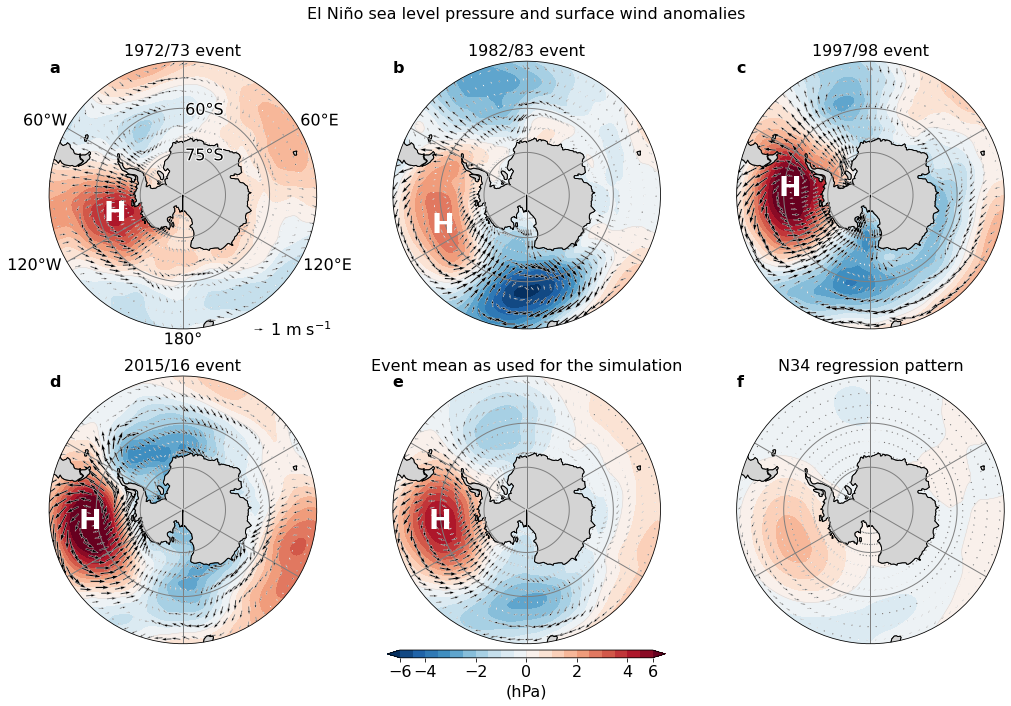

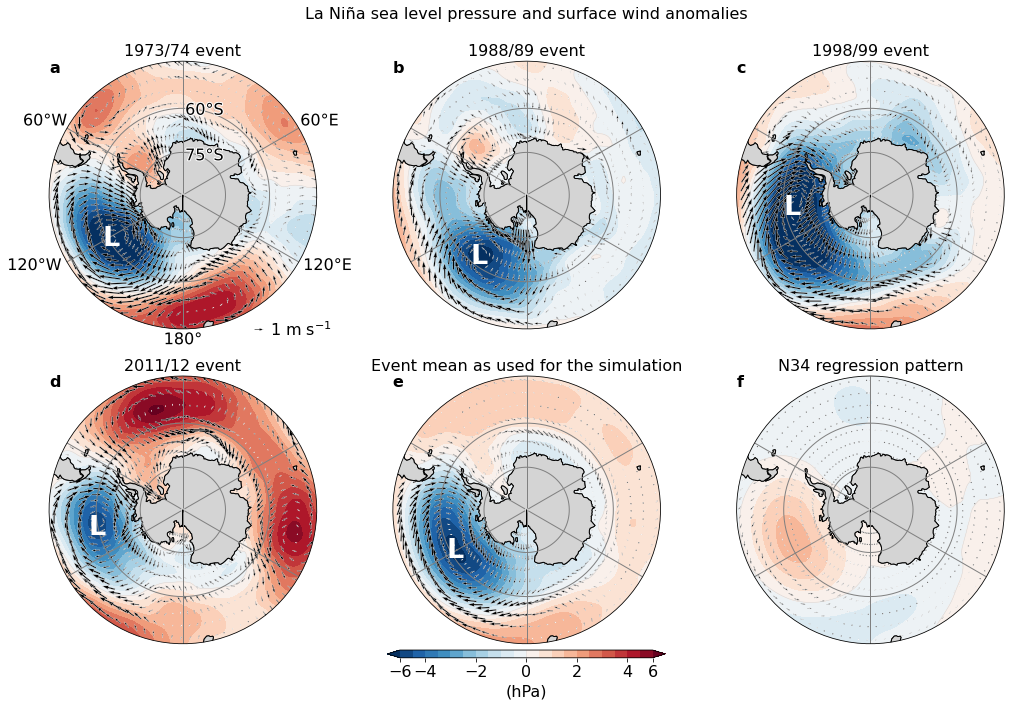

In [19]:
%%time
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
# ------------------------------------------------------------------- #

event = ['El Niño', 'La Niña']
skala = 30

EN_periods = [168  + 6,168 + 18,
              288  + 6,288 + 18,
              467  + 6,467 + 18,
              683  + 6,683 + 18] 
LN_periods = [168 + 18,168 + 30,
              347 + 18,347 + 30,
              468 + 18,468 + 30,
              612 + 18,612 + 30]        

var   = ['psl', 'uas', 'vas']
base  = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_anom/JRA55-do-1-3_'

# ---------------------------- subplot 1 ---------------------------- #
for e in range(2):
    # initialise figure
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2, 3) 

    if e == 0: 
        periode = EN_periods; titel = 'El Niño sea level pressure and surface wind anomalies'; save_fig = 'El_Nino';
        offset_from_start = [6, 18] # select months 6-18 of El Niño event, i.e. only the peak
        suffix = '_EN'; SI_filenr = '3'
        jahre = ['1972', '1982', '1997', '2015']
    if e == 1:
        periode = LN_periods; titel = 'La Niña sea level pressure and surface wind anomalies'; save_fig = 'La_Nina';
        offset_from_start = [18, 30] # select months 6-18 of El Niño event, i.e. only the peak
        suffix = '_LN'; SI_filenr = '4'
        jahre = ['1973', '1988', '1998', '2011']
    
    for f in [0,2,4,6,8,10]: # loop through the four events + mean event + N34 regression
        if f in [0,2,4,6]:
            # load in slp and divide by 100 to get (hPa)
            slp_anom = xr.open_dataset(base + var[0] + '_monthly_anom_1958-2018.nc').psl[periode[f]:periode[f+1],:,:].mean('time').load() / 100 
            uas_anom = xr.open_dataset(base + var[1] + '_monthly_anom_1958-2018.nc').uas[periode[f]:periode[f+1],:,:].mean('time').load()
            vas_anom = xr.open_dataset(base + var[2] + '_monthly_anom_1958-2018.nc').vas[periode[f]:periode[f+1],:,:].mean('time').load()
            
            # for saving the data later on in a netcdf file
            if f == 0: slp_map1 = slp_anom; uas_map1 = uas_anom; vas_map1 = vas_anom
            if f == 2: slp_map2 = slp_anom; uas_map2 = uas_anom; vas_map2 = vas_anom
            if f == 4: slp_map3 = slp_anom; uas_map3 = uas_anom; vas_map3 = vas_anom
            if f == 6: slp_map4 = slp_anom; uas_map4 = uas_anom; vas_map4 = vas_anom            
            
        if f in [8]:
            slp_anom = xr.open_dataset(base + var[0] + '_monthly_anom_1958-2018.nc').psl # load in slp and divide by 100 to get (hPa)
            slp_anom = ((slp_anom[periode[0]:periode[1],:,:].mean('time') + 
                         slp_anom[periode[2]:periode[3],:,:].mean('time') +
                         slp_anom[periode[4]:periode[5],:,:].mean('time') + 
                         slp_anom[periode[6]:periode[7],:,:].mean('time'))/4) / 100 
           
            uas_anom = xr.open_dataset(base + var[1] + '_monthly_anom_1958-2018.nc').uas 
            uas_anom = ((uas_anom[periode[0]:periode[1],:,:].mean('time') + uas_anom[periode[2]:periode[3],:,:].mean('time') +
                         uas_anom[periode[4]:periode[5],:,:].mean('time') + uas_anom[periode[6]:periode[7],:,:].mean('time'))/4)
            vas_anom = xr.open_dataset(base + var[2] + '_monthly_anom_1958-2018.nc').vas
            vas_anom = ((vas_anom[periode[0]:periode[1],:,:].mean('time') + vas_anom[periode[2]:periode[3],:,:].mean('time') +
                         vas_anom[periode[4]:periode[5],:,:].mean('time') + vas_anom[periode[6]:periode[7],:,:].mean('time'))/4)
            
            slp_map5 = slp_anom; uas_map5 = uas_anom; vas_map5 = vas_anom

        if f in [10]:
            ds = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_N34_full_time_series.nc')
            slp_anom = ds.psl / 100; uas_anom = ds.uas_10m; vas_anom = ds.vas_10m   

        if e == 0:
            stitel = ['1972/73 event', '1982/83 event', '1997/98 event', '2015/16 event', 'Event mean as used for the simulation', 'N34 regression pattern']
        if e == 1:
            stitel = ['1973/74 event', '1988/89 event', '1998/99 event', '2011/12 event', 'Event mean as used for the simulation', 'N34 regression pattern']
        
        if f == 0: panel = gs[0,0];  subtitel = stitel[0]; ascii_nr = 0
        if f == 2: panel = gs[0,1];  subtitel = stitel[1]; ascii_nr = 1
        if f == 4: panel = gs[0,2];  subtitel = stitel[2]; ascii_nr = 2
        if f == 6: panel = gs[1,0];  subtitel = stitel[3]; ascii_nr = 3
        if f == 8: panel = gs[1,1];  subtitel = stitel[4]; ascii_nr = 4
        if f == 10: panel = gs[1,2]; subtitel = stitel[5]; ascii_nr = 5
        
        ax1 = plt.subplot(panel, projection=ccrs.SouthPolarStereo(central_longitude=0))
        ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
        p1  = slp_anom.plot.contourf(ax=ax1, levels = np.linspace(-5,5,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = slp_anom.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree()) #d4d4d4 = lightgrey = [.83, .83, .83] in HEX
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #   

        # plot markers of maximum anomaly amplitude
                           # max lon EN,   max lat EN, max lon LN,   max lat LN
        # peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
        if f in [0,2,4,6,8] and e == 0: 
            peak_anom_lon = slp_anom[0:80,:].where(slp_anom[0:80,:] == slp_anom[0:80,:].max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude south of 45°S
            peak_anom_lat = slp_anom[0:80,:].where(slp_anom[0:80,:] == slp_anom[0:80,:].max(), drop=True).lat 

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_lon[0], peak_anom_lat[0], 'H', c='w', fontsize=27, 
                           fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker

        if f in [0,2,4,6,8] and e == 1: # same approach but a MINUS sign for La Niña ASL anomalies
            peak_anom_lon = slp_anom[0:80,:].where(slp_anom[0:80,:] == slp_anom[0:80,:].min(), drop=True).lon 
            peak_anom_lat = slp_anom[0:80,:].where(slp_anom[0:80,:] == slp_anom[0:80,:].min(), drop=True).lat 

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_lon[0], peak_anom_lat[0], 'L', c='w', fontsize=27, 
                           fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker

        # Add the wind stress arrows, only plotting every 30th data point.
        mask = np.logical_or(uas_anom[0] != 0,uas_anom[1] !=0) ## <-- corrected: one operation less
        X = uas_anom.lon; Y = uas_anom.lat; U = uas_anom; V = vas_anom; abstand = 7 # specifics for the wind speed arrows
        
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
        Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), scale=skala, 
                       scale_units='height', minshaft=2, transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w'))        
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
                   
        if f == 0: # add reference key,  x0,   y0 of quiver key
            qk = plt.quiverkey(Q, .8, 0, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel
            
            # add labels
            xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
            ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
            txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S'] # label text

            # loop through the 7 labels and surround with white space for higher visibility
            for l in range(len(txt_lab)):
                ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                        fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
                

        ax1.text(0, .96, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        fancy_plot(ax1); plt.title(subtitel, fontsize=16)

    cax = fig.add_axes([.379, -.005, .24125, .012]) # position: [x0, y0, width, height]
    cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
    cb.set_label(label='(hPa)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p11) # add contours to colour bar

    plt.suptitle(titel, fontsize=16, y=1)
    # --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
    plt.savefig(save + save_fig + '_sea_level_pressure_and_wind_anomalies_events_mean_and_N34_regression', #
                dpi=300, facecolor='w',                                                                    #
                edgecolor='w', orientation='landscape',                                                    #
                format=None, transparent=False, bbox_inches='tight',                                       #
                pad_inches=0.1, metadata=None)                                                             #
    # --- end of script ---------------------------------------------------------------------------------- # 
    
    # saving the data as a netcdf file
    ds3 = xr.Dataset({'SLP_anoms_' + suffix + jahre[0]: slp_map1,
                      'UAS_anoms_' + suffix + jahre[0]: uas_map1,
                      'VAS_anoms_' + suffix + jahre[0]: vas_map1,

                      'SLP_anoms_' + suffix + jahre[1]: slp_map2,
                      'UAS_anoms_' + suffix + jahre[1]: uas_map2,
                      'VAS_anoms_' + suffix + jahre[1]: vas_map2,                

                      'SLP_anoms_' + suffix + jahre[2]: slp_map3,
                      'UAS_anoms_' + suffix + jahre[2]: uas_map3,
                      'VAS_anoms_' + suffix + jahre[2]: vas_map3,                 

                      'SLP_anoms_' + suffix + jahre[3]: slp_map4,
                      'UAS_anoms_' + suffix + jahre[3]: uas_map4,
                      'VAS_anoms_' + suffix + jahre[3]: vas_map4,

                      'SLP_anoms_' + suffix + '_composite_mean': slp_map5,
                      'UAS_anoms_' + suffix + '_composite_mean': uas_map5,
                      'VAS_anoms_' + suffix + '_composite_mean': vas_map5},
                     attrs=dict(Units='[hPa, m s$^{-1}$]', 
                                Author = 'Maurice F. Huguenin', 
                                Created = '2023-06-14', 
                                Mail = 'm.huguenin-virchaux@unsw.edu.au', 
                                Funding = 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'))
    ds3.to_netcdf('/g/data/e14/mv7494/ENSOAnt_data/FigS' + SI_filenr + '_Spatial_Patterns_Events_and_Composite_Mean' + suffix + '.nc')
    # Wall time: 1min 21s    

### Same data but ROBINSON projection

CPU times: user 52 s, sys: 9.05 s, total: 1min 1s
Wall time: 50 s


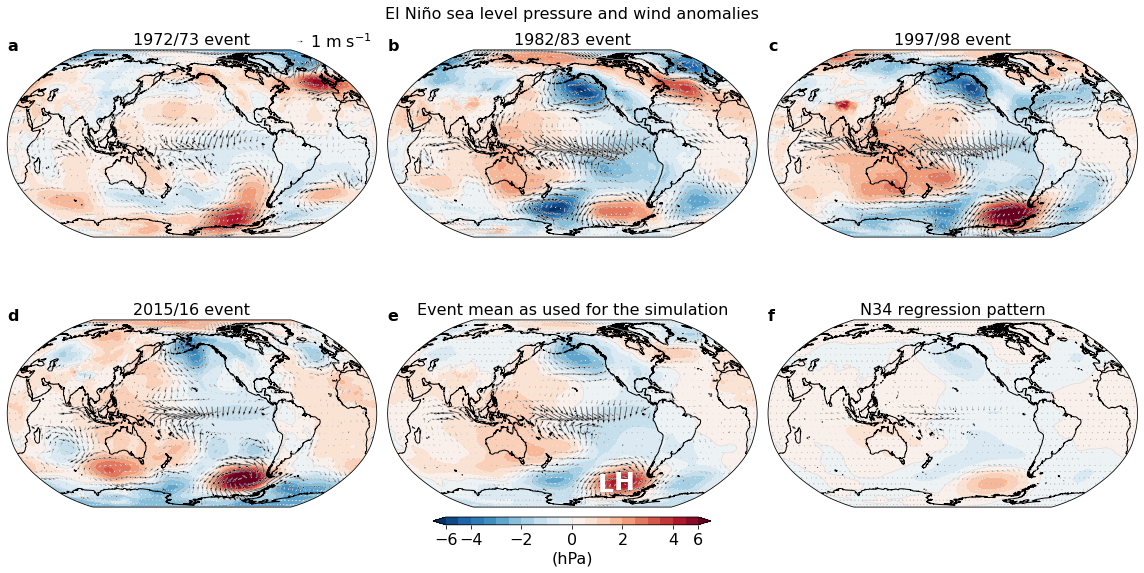

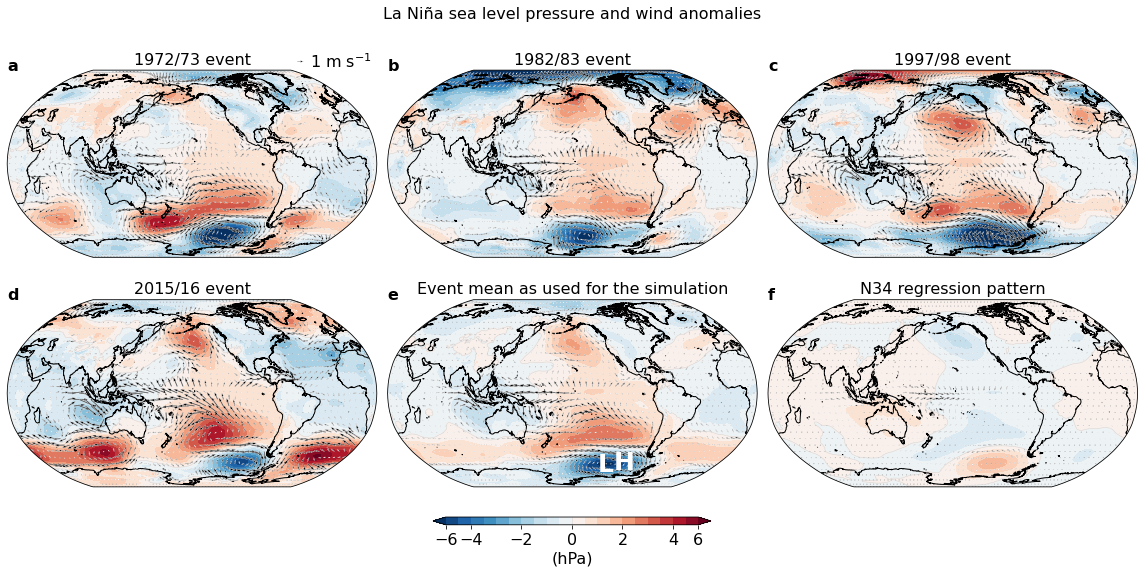

In [3]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
    plt.title(subtitel, fontsize=16)
# ------------------------------------------------------------------- #

event = ['El Niño', 'La Niña']
skala = 30
var = ['psl', 'uas', 'vas']
base = '/g/data/e14/mv7494/JRA55-do-1-3/monthly_anom/JRA55-do-1-3_'
# ---------------------------- subplot 1 ---------------------------- #
for e in range(2):
    # initialise figure
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2, 3) 

    if e == 0: periode = EN_periods; titel = 'El Niño sea level pressure and wind anomalies'; save_fig = 'El_Nino'
    if e == 1: periode = LN_periods; titel = 'La Niña sea level pressure and wind anomalies'; save_fig = 'La_Nina'
    
    for f in [0,2,4,6,8,10]: # loop through the four events + mean event + N34 regression
        if f in [0,2,4,6]:
            # load in slp and divide by 100 to get (hPa)
            slp_anom = xr.open_dataset(base + var[0] + '_monthly_anom_1958-2018.nc').psl[periode[f]:periode[f+1],:,:].mean('time').load() / 100 
            uas_anom = xr.open_dataset(base + var[1] + '_monthly_anom_1958-2018.nc').uas[periode[f]:periode[f+1],:,:].mean('time').load()
            vas_anom = xr.open_dataset(base + var[2] + '_monthly_anom_1958-2018.nc').vas[periode[f]:periode[f+1],:,:].mean('time').load()

        if f in [8]:
            slp_anom = xr.open_dataset(base + var[0] + '_monthly_anom_1958-2018.nc').psl # load in slp and divide by 100 to get (hPa)
            slp_anom = ((slp_anom[periode[0]:periode[1],:,:].mean('time') + 
                         slp_anom[periode[2]:periode[3],:,:].mean('time') +
                         slp_anom[periode[4]:periode[5],:,:].mean('time') + 
                         slp_anom[periode[6]:periode[7],:,:].mean('time'))/4) / 100 
           
            uas_anom = xr.open_dataset(base + var[1] + '_monthly_anom_1958-2018.nc').uas 
            uas_anom = ((uas_anom[periode[0]:periode[1],:,:].mean('time') + uas_anom[periode[2]:periode[3],:,:].mean('time') +
                         uas_anom[periode[4]:periode[5],:,:].mean('time') + uas_anom[periode[6]:periode[7],:,:].mean('time'))/4)
            vas_anom = xr.open_dataset(base + var[2] + '_monthly_anom_1958-2018.nc').vas
            vas_anom = ((vas_anom[periode[0]:periode[1],:,:].mean('time') + vas_anom[periode[2]:periode[3],:,:].mean('time') +
                         vas_anom[periode[4]:periode[5],:,:].mean('time') + vas_anom[periode[6]:periode[7],:,:].mean('time'))/4)
        if f in [10]:
            ds = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_N34_full_time_series.nc')
            slp_anom = ds.psl / 100; uas_anom = ds.uas_10m; vas_anom = ds.vas_10m         

        if f == 0: panel = gs[0,0]; subtitel = '1972/73 event'; ascii_nr = 0
        if f == 2: panel = gs[0,1]; subtitel = '1982/83 event'; ascii_nr = 1
        if f == 4: panel = gs[0,2]; subtitel = '1997/98 event'; ascii_nr = 2
        if f == 6: panel = gs[1,0]; subtitel = '2015/16 event'; ascii_nr = 3
        if f == 8: panel = gs[1,1]; subtitel = 'Event mean as used for the simulation'; ascii_nr = 4
        if f == 10: panel = gs[1,2]; subtitel = 'N34 regression pattern'; ascii_nr = 5
        
        ax1 = plt.subplot(panel, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
        
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
        p1  = slp_anom.plot.contourf(ax=ax1, levels = np.linspace(-5,5,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = slp_anom.plot.contour(levels = [0], linewidths=.5, cmap='#d4d4d4', transform=ccrs.PlateCarree()) #d4d4d4 = lightgrey = [.83, .83, .83] in HEX
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
        
        if f == 8: # plot markers of maximum anomaly amplitude
                               # max lon EN,   max lat EN, max lon LN,   max lat LN
            peak_anom_coords = [   262.6875, -59.81267266,     240.75, -61.49753151] # unfortunately I have to hardcode those as the loop goes over EN & LN and I want two markers
            # peak_anom_coords = slp_anom.where(slp_anom == slp_anom.max(), drop=True).lon # this is how I get the coordinates of the maximum anomaly amplitude
            lon_peak_LN_anom = slp_anom.where(slp_anom == slp_anom.min(), drop=True).lon
            lat_peak_LN_anom = slp_anom.where(slp_anom == slp_anom.min(), drop=True).lat 

            # plot white text marker where I have the maximum amplitudes as UNICODE +/- signs
            txt = plt.text(peak_anom_coords[0], peak_anom_coords[1], 'H', c='w', fontsize=25, 
                           fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center') # horizontally and vertically aligned marker
            txt = plt.text(peak_anom_coords[2], peak_anom_coords[3], 'L', c='w', fontsize=25, 
                           fontweight='bold', transform=ccrs.PlateCarree(), ha='center', va='center')
          

  
        # Add the wind stress arrows, only plotting every 30th data point.
        mask = np.logical_or(uas_anom[0] != 0,uas_anom[1] !=0) ## <-- corrected: one operation less
        X = uas_anom.lon; Y = uas_anom.lat; U = uas_anom; V = vas_anom; abstand = 10# specifics for the wind speed arrows
        
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
        Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), scale=skala, 
                       scale_units='height', minshaft=2, transform=ccrs.PlateCarree(), linewidths=.3, edgecolor=('w'))
        # ---------------------------------------------------------------------------------------------------------------------------------------------- #                    
                   # add reference key,  x0,   y0 of quiver key
        if f == 0: qk = plt.quiverkey(Q, .8, 1.05, 1, r'1 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) # add quiver if first subpanel

        ax1.text(0, 1, string.ascii_lowercase[ascii_nr], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        fancy_plot(ax1)

    cax = fig.add_axes([.379, .1, .24125, .012]) # position: [x0, y0, width, height]
    cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal'); 
    cb.set_label(label='(hPa)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks(); cb.add_lines(p11) # add contours to colour bar

    plt.suptitle(titel, fontsize=16, y=.9)
# --- saving as 300 dpi .PNG image in specified folder -------------------------------------------------------- #
plt.savefig(save + save_fig + '_sea_level_pressure_and_wind_anomalies_events_mean_and_N34_regression_Robinson', #
            dpi=300, facecolor='w',                                                                             #
            edgecolor='w', orientation='landscape',                                                             #
            format=None, transparent=False, bbox_inches='tight',                                                #
            pad_inches=0.1, metadata=None)                                                                      #
# --- end of script ------------------------------------------------------------------------------------------- # 
# Wall time: 1min 21s

Here only show wind anomalies with a magnitude larger than 2 m s$^{-1}$.

In [4]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #